In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as ran
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#!wget https://vincentarelbundock.github.io/Rdatasets/csv/DAAG/dengue.csv

In [41]:
data = pd.read_csv('dengue.csv',delimiter=',')
#Z=data['Purchase'].copy()
llaves = ['humid', 'temp' , 'h10pix', 'trees' , 'Xmin', 'Ymin']
data = data[llaves].dropna()
clusters = KMeans(n_clusters=4)
maxClusters = 20
inertia0 = np.zeros(maxClusters-1)

for j in range(1,maxClusters):
    clusters = KMeans(n_clusters=j)
    clusters.fit(data)
    inertia0[j-1] = clusters.inertia_

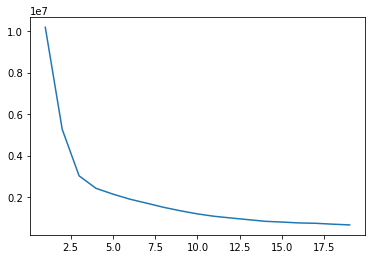

In [43]:
plt.plot(np.arange(1,maxClusters), inertia0)

In [44]:
inertia0

array([10182855.09889696,  5265635.6784609 ,  3020424.54564273,
        2419906.54396151,  2142344.43643371,  1897668.89743359,
        1703754.03177595,  1505500.72634324,  1336779.56831684,
        1188849.79919202,  1072297.38648787,   989628.45600634,
         910249.4480781 ,   831878.19011294,   794123.00585066,
         753389.50997439,   735301.77014448,   692750.77012219,
         657383.05429675])

# 